In [1]:
library(ggplot2)
library(dplyr)
library(reshape2)
library(gridExtra)

Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'reshape2' was built under R version 3.6.3"Warning message:
"package 'gridExtra' was built under R version 3.6.3"
Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



In [2]:
N <- 1000
a <- 0.012
b <- -0.09
k <- function(n=1){
        k<-runif(n,0.16,0.25)
        return(k)
        }
max_s_prop <- 0.7
age_max <- 70
age_step <- 1
N_iter=10

In [3]:
multi_sim <- function(N,a,b,k,max_s_prop,age_max,age_step,N_iter){
    multipop<-NA
    for(replicats in 1:N_iter){
        pop <- matrix(,nrow=4,ncol=age_max)
        rownames(pop)<-c("age","Smurf_prop","n_NS","n_S")
        pop[1,]<- seq(0,age_max-1,age_step)
        cbind.na <- function(x, y){
            n <- max(length(x), length(y))
            length(x) <- n              
            length(y) <- n
            combined<-cbind(x,y)
            combined[which(is.na(combined))]<-0
            return(combined)
        }

        Smurf <- function(age){
            age_func <- a*age+b
            smurf_prop <- ifelse(age_func>0, ifelse(age_func<max_s_prop,runif(1,0,age_func*2),runif(1,0,max_s_prop)),0)
            return(smurf_prop)
        }

    pop[3,1]<-N
    for(i in pop[1,]){pop[2,i]<-Smurf(i)}
    pop[4,1]<-round(pop[3,1]*pop[2,1], 0)
    i=0
    for(j in 2:length(pop[2,])){
       i=i+1 
       pop[4,j]<-round(pop[3,i]*pop[2,j] ,0)
       pop[3,j]<-pop[3,i]-pop[4,j] 
    }
    pop<-pop[,-length(pop[1,])]
    #pop

    kill_Smurfs <- function(n_S){
        dyingSmurfs <- NA
        dyingSmurfs[1]<-round(n_S-n_S*exp(-k()),0)
        i<-1
        while(n_S>0){
            i=i+1
            n_S<-dyingSmurfs[i-1]
            dyingSmurfs[i]<-round(n_S-n_S*exp(-k()),0)
        }
        return(dyingSmurfs)
    }


    Smurf_death<-kill_Smurfs(pop[4,1])
    length(Smurf_death)<-10; Smurf_death[which(is.na(Smurf_death))]<-0
    for(i in pop[4,2:length(pop[4,])]){
        Smurf_death<-cbind.na(Smurf_death,kill_Smurfs(i))
    }
Smurf_death<-cbind(pop[4,],t(Smurf_death))
Smurf_death[is.na(Smurf_death)]<-0
Smurf_death<-as.data.frame(Smurf_death)
rownames(Smurf_death)<-pop[1,]
colnames(Smurf_death)<-seq(1:length(Smurf_death[1,]))
#Smurf_death

Smurfs_dyn<-NA
length(Smurfs_dyn)<-80
for(i in 1:length(Smurf_death[,1])){
    temp<-c(rep(NA,i-1),Smurf_death[i,])
    length(temp)<-80
    Smurfs_dyn<-rbind(Smurfs_dyn,temp)
    }
Smurfs_dyn<-as.data.frame(Smurfs_dyn[-1,])
colnames(Smurfs_dyn)<-seq(1,80,1)
rownames(Smurfs_dyn)<-pop[1,]
Smurfs_dyn[,1:80][Smurfs_dyn[,1:80] == "NULL"] <- 0
#Smurfs_dyn

Smurfs_alive<-NA
length(Smurfs_alive)<-80
for(i in 1:80){Smurfs_alive[i]=sum(as.numeric(Smurfs_dyn[,i]),na.rm=TRUE)}
pop<-rbind(pop,t(Smurfs_alive[1:69]))
rownames(pop)<-c("age","Smurf_prop","n_NS","n_S","S_alive")
#pop

Smurf_surv<-as.data.frame(apply(Smurf_death,2,sum))
Smurf_surv<-cbind(as.numeric(colnames(Smurf_death)),Smurf_surv)
rownames(Smurf_surv)<-NULL
colnames(Smurf_surv)<-c("timeAsSmurf","Smurfs_alive")
#head(Smurf_surv)
        
        multipop<-rbind(multipop,t(rbind(replicats,pop)))
        
#return(pop)
}
multipop<-as.data.frame(multipop[-1,])
multipop<-multipop%>%relocate('age')
rownames(multipop)<-NULL
return(multipop)
}

In [4]:
sims<-suppressWarnings(multi_sim(N,a,b,k,max_s_prop,age_max,age_step, N_iter=100))

In [5]:
age_max<-min(sims$age[which(sims$n_NS<1)])+5
sims<-sims[sims$age<(age_max),]
rownames(sims)<-NULL
age_prob<-as.data.frame(na.omit(sims[((sims$S_alive/(sims$n_NS+sims$S_alive))<0.1)&((sims$S_alive/(sims$n_NS+sims$S_alive))>0.04),]$age, freq=FALSE, include.lowest=TRUE, breaks=20))
colnames(age_prob)<-"age"

Warning message:
"Removed 2 rows containing missing values (geom_bar)."`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
Warning message:
"Removed 55 rows containing missing values (geom_point)."Warning message:
"Removed 56 rows containing missing values (geom_point)."`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
Warning message:
"Removed 88 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 583 rows containing missing values (geom_point)."Warning message:
"Removed 9 rows containing missing values (geom_smooth)."

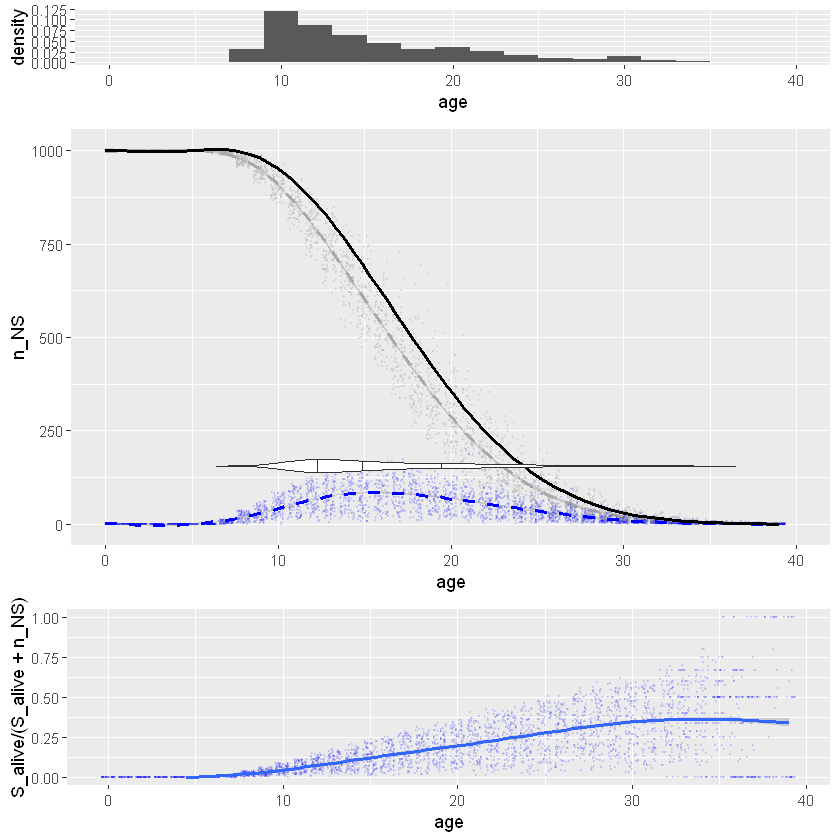

In [6]:
transparent_theme <- theme(
    axis.title.x = element_blank(),
    axis.title.y = element_blank(),
    axis.text.x = element_blank(), 
    axis.text.y = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    axis.line = element_blank(),
    panel.background = element_rect(fill = "transparent",colour = NA),
    plot.background = element_rect(fill = "transparent",colour = NA))

p<-ggplot(age_prob, aes(x=age,y=age))+
    geom_violin(draw_quantiles = c(0.25, 0.5, 0.75),trim=FALSE)+
    ylim(0,age_max)+
    transparent_theme+
    coord_flip()
p_grob<-ggplotGrob(p)

surv_plot<-ggplot(sims)+
    geom_jitter(aes(x=age,y=n_NS),size=0.1,color='dark grey', alpha=0.2)+
    geom_smooth(aes(x=age,y=n_NS),color='dark grey', linetype='dashed')+
    geom_jitter(aes(x=age,y=S_alive),size=0.1,color='blue', alpha=0.1)+
    geom_smooth(aes(x=age,y=S_alive),color='blue', linetype='dashed')+
    geom_smooth(aes(x=age,y=n_NS+S_alive),color='black')+
    #annotate("rect",xmin=min(sims[sims$S_alive>sims$n_NS,]$age), xmax=Inf, ymin=0, ymax=Inf, alpha=0.2, fill="black", label="n Smurfs > n non-Smurfs")
    #annotate("rect",xmin=min(sims[((sims$S_alive/(sims$n_NS+sims$S_alive))<0.1)&((sims$S_alive/(sims$n_NS+sims$S_alive))>0.04),]$age,na.rm=TRUE), xmax=max(sims[((sims$S_alive/(sims$n_NS+sims$S_alive))<0.1)&((sims$S_alive/(sims$n_NS+sims$S_alive))>0.04),]$age,na.rm=TRUE), ymin=0, ymax=Inf, alpha=0.2, fill="red")    
    xlim(0,age_max)+annotation_custom(grob=p_grob,xmin=0,xmax=age_max,ymin=100, ymax=200)
    
age_dist<-ggplot(age_prob, aes(x=age))+
    geom_histogram(aes(y=..density..), binwidth = 2)+
    xlim(0,age_max)

smurf_prop<-ggplot(sims,(aes(x=age,y=S_alive/(S_alive+n_NS))))+
    geom_jitter(color="blue", size=0.01, alpha=0.1)+
    geom_smooth()+
    ylim(0,1)

grid.arrange(age_dist, surv_plot, smurf_prop,ncol=1, nrow=3, heights=c(1,4,2))

Warning message:
"Removed 62 rows containing missing values (geom_violin)."

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
Warning message:
"Removed 85 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 571 rows containing missing values (geom_point)."Warning message:
"Removed 9 rows containing missing values (geom_smooth)."

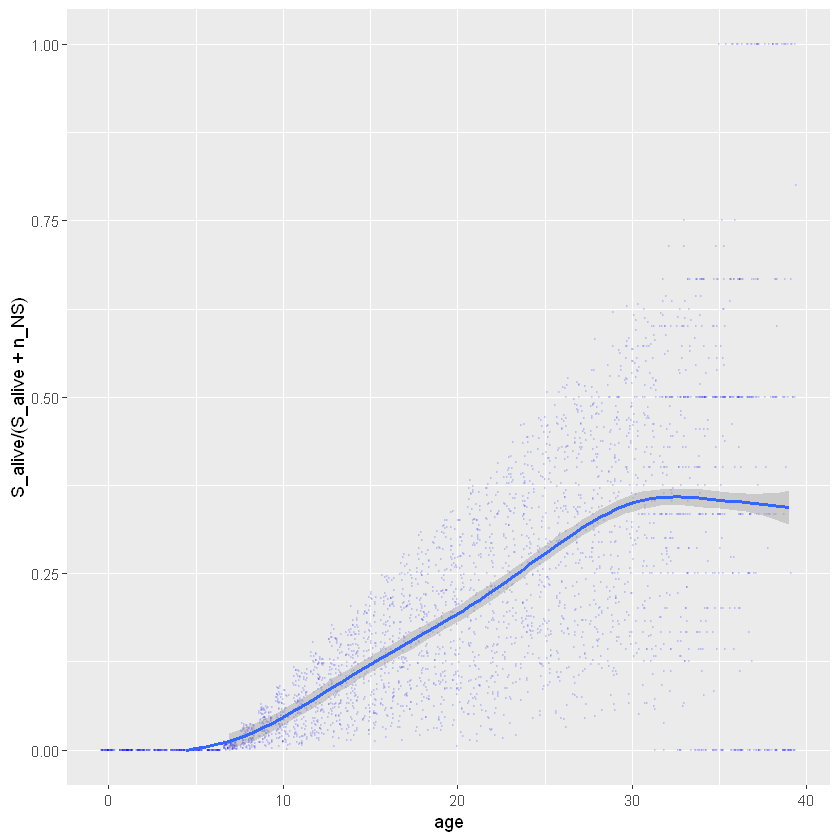

In [ ]:
ggplot(sims,(aes(x=age,y=S_alive/(S_alive+n_NS))))+
    geom_jitter(color="blue", size=0.01, alpha=0.1)+
    geom_smooth()+
    ylim(0,1)+annotation_custom(grob=p_grob,xmin=0,xmax=age_max,ymin=100, ymax=200)